## Model metrics

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from metrics_utils import *

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping


In [2]:
LOG_PATH = "lightning_logs"
METRICS_PATH = "../Metrics"
model_ids = ['g_lenet_cut_dataset_repeat',
             'lenet_cut_dataset_repeat',
             'resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
             'jiaresnet50_cut_dataset_repeat',
             'g_resnet18_cut_dataset_repeat',
             'g_resnet18_old_cut_dataset_repeat']

## Training metrics

In [3]:
repeat_metrics = get_results_runs(model_ids,'val',METRICS_PATH)
repeat_metrics.head(7)

lenet_cut_dataset_repeat: Removed 4 NaNs


Model,Loss,Accuracy,ECE,C Viol
g_lenet_cut_dataset_repeat,0.7821 ± 0.0351,77.54% ± 2.58%,0.1587 ± 0.0089,0.4174 ± 0.2577
lenet_cut_dataset_repeat,0.8562 ± 0.0341,70.61% ± 3.42%,0.1421 ± 0.0146,-0.6823 ± 0.0000
resnet18_cut_dataset_repeat,0.5290 ± 0.0003,98.16% ± 0.12%,0.2273 ± 0.0023,0.4963 ± 0.1710
resnet50_cut_dataset_repeat,0.5309 ± 0.0002,97.40% ± 0.13%,0.2195 ± 0.0031,0.7647 ± 0.3068
jiaresnet50_cut_dataset_repeat,0.5310 ± 0.0034,97.65% ± 0.82%,0.2232 ± 0.0066,0.2887 ± 0.0618
g_resnet18_cut_dataset_repeat,0.5324 ± 0.0004,98.04% ± 0.32%,0.2285 ± 0.0041,-0.3925 ± 0.1478
g_resnet18_old_cut_dataset_repeat,0.5346 ± 0.0024,97.79% ± 0.25%,0.2235 ± 0.0041,0.5458 ± 0.1820


## Testing metrics

In [3]:
repeat_metrics = get_results_runs(model_ids,'test',METRICS_PATH)
repeat_metrics.head(7)

g_lenet_cut_dataset_repeat: Removed 4 NaNs
lenet_cut_dataset_repeat: Removed 5 NaNs
resnet18_cut_dataset_repeat: Removed 1 NaNs
resnet50_cut_dataset_repeat: Removed 1 NaNs
g_resnet18_cut_dataset_repeat: Removed 1 NaNs


/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/share/nas2/npower/miniconda3/envs/mphys-galaxy/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

Model,Loss,Accuracy,ECE,C Viol
g_lenet_cut_dataset_repeat,0.5098 ± 0.0087,89.53% ± 0.28%,0.1545 ± 0.0085,0.1405 ± 0.0000
lenet_cut_dataset_repeat,0.5192 ± 0.0095,89.60% ± 0.60%,0.1797 ± 0.0121,nan ± nan
resnet18_cut_dataset_repeat,0.4514 ± 0.0075,92.18% ± 0.29%,0.1109 ± 0.0040,0.9351 ± 0.3880
resnet50_cut_dataset_repeat,0.4579 ± 0.0077,92.32% ± 0.37%,0.1201 ± 0.0060,1.3171 ± 0.4113
jiaresnet50_cut_dataset_repeat,0.4075 ± 0.0023,94.27% ± 0.06%,0.1171 ± 0.0063,0.0117 ± 0.0550
g_resnet18_cut_dataset_repeat,0.4119 ± 0.0298,93.33% ± 1.10%,0.1053 ± 0.0082,0.7135 ± 0.3542
g_resnet18_old_cut_dataset_repeat,0.4723 ± 0.0548,91.09% ± 1.64%,0.1063 ± 0.0089,0.3742 ± 0.5673


In [9]:
#          blue      orange     reddish purple  sky blue   bluish green  amber        vermillion  
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",   "#F5C710",  "#D55E00"  ]
colours = ["#0072B2","#E69F00","#CC79A7",       "#56B4E9",  "#009E73",  "#D55E00","#D55E00"  ]

def plot_combined_metrics(model_ids,metric,metric_label):
    fig = plt.figure(figsize=(9,4))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(metric_label)

    for i,model in enumerate(model_ids):
        metrics = get_metrics_from_csv(model,METRICS_PATH,version=2,mode='train')
        m = metrics[metric]
        epoch = metrics.index
        label = model.removesuffix('_cut_dataset_repeat')
        ax1.plot(epoch,m,linestyle='-',c=colours[i],label=label,linewidth=1.7)
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.grid()
    plt.show()

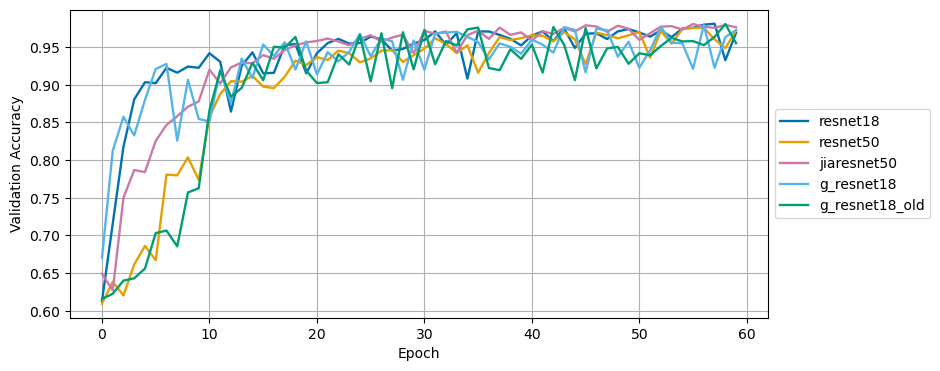

In [10]:
plot_combined_metrics(model_ids,'val_acc','Validation Accuracy')

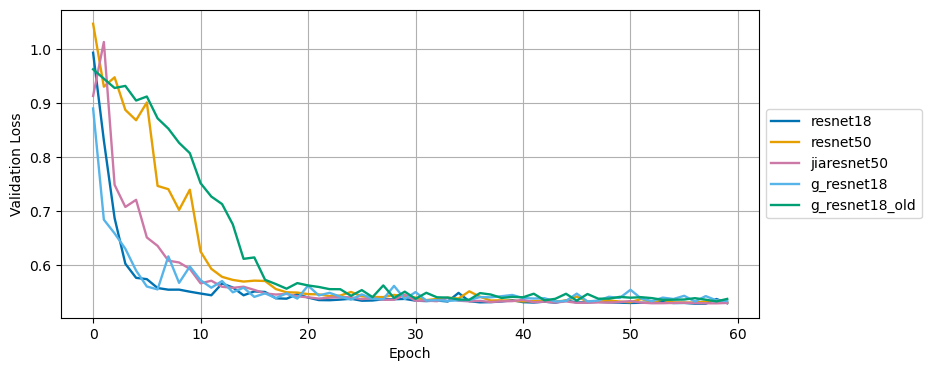

In [11]:
plot_combined_metrics(model_ids,'val_loss','Validation Loss')

## Prediction Metrics

In [ ]:
def summarise_predictions(model_id,dataset_name,version=0):
    predictions = pd.read_csv(f"{METRICS_PATH}/{model_id}/version_{version}/{dataset_name}_predictions.csv", names=['CW','ACW','Other'],on_bad_lines = 'skip').astype('float')
    argmax_predictions = predictions.idxmax(axis=1)
    num_acw = argmax_predictions[argmax_predictions=='ACW'].shape[0]
    num_cw = argmax_predictions[argmax_predictions=='CW'].shape[0]
    num_other = argmax_predictions[argmax_predictions=='Other'].shape[0]
    num = argmax_predictions.shape[0]
    print(f"Total: {num}. ACW: {num_acw} ({num_acw/num:.1%}). CW: {num_cw} ({num_cw/num:.1%}). Other: {num_other} ({num_other/num:.1%})")
    print(f"Chirality Violation: {chirality_violation(predictions):3.2f} sigma")

#summarise_predictions("resnet18_cut_dataset","full_desi_dataset")

In [9]:
model_ids = ['resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
            'jiaresnet50_cut_dataset_repeat',
            #'g_resnet18_cut_dataset_repeat',
             'g_resnet18_old_cut_dataset_repeat']

repeat_metrics = get_predict_results_runs(model_ids,5,METRICS_PATH)
repeat_metrics.head(6)

Model,ACW,CW,Other,C Viol
resnet18_cut_dataset_repeat,13966 (1.4%) ± 1589,12388 (1.2%) ± 1590,973646 (97.4%) ± 3133,10.18 ± 3.78
resnet50_cut_dataset_repeat,13876 (1.4%) ± 1187,11588 (1.2%) ± 997,974536 (97.5%) ± 1911,14.25 ± 6.61
jiaresnet50_cut_dataset_repeat,13403 (1.3%) ± 909,13440 (1.3%) ± 917,973157 (97.3%) ± 1822,-0.09 ± 0.64
g_resnet18_old_cut_dataset_repeat,15442 (1.5%) ± 5041,14968 (1.5%) ± 5950,969590 (97.0%) ± 10193,3.70 ± 27.71


In [21]:
def get_predict_results_runs_cviol(model_ids,c_viols_list,max_runs=5,dataset_name="cut_dataset"):
    repeat_metrics = pd.DataFrame(columns=["C Viol", "C Viol Err"],index=model_ids)
    repeat_metrics.columns.name="Model"
    for model in model_ids:
        c_viols = []
        c_viols_err = []
        for c_viol in c_viols_list:
            predicted_c_viols = []
            for run in range(max_runs):
                try:
                    predictions = pd.read_csv(f"{METRICS_PATH}/{model}/version_{run}/{dataset_name}_CVIOL_{c_viol}_predictions.csv",header=None,names=['CW','ACW','Other'], on_bad_lines = 'skip').astype('float')
                    predicted_c_viols.append(chirality_violation(predictions))
                except:
                    print(f"Error with {model}, run {run}, cviol {c_viol}")
            c_viols.append(np.average(predicted_c_viols))
            c_viols_err.append(np.std(predicted_c_viols))
        
        repeat_metrics.loc[model] = {"C Viol": c_viols,
                                        "C Viol Err": c_viols_err}
    return repeat_metrics


def plot_cviols(repeat_metrics,model_ids,c_viols_list):
    fig = plt.figure(figsize=(9,7))
    # ax1 = fig.add_subplot(111)
    # ax1.set_ylabel('Predicted C Viol')
    # ax1.set_xlabel('Actual C Viol')

    for i,model in enumerate(model_ids):
        ax = fig.add_subplot(3,2,i+1)
        ax.set_ylabel('Model Predicted C Viol')
        ax.set_xlabel('Test Dataset Actual C Viol')
        c_viols = repeat_metrics["C Viol"].iloc[i]
        c_viols_err = repeat_metrics["C Viol Err"].iloc[i]
        label = model.removesuffix('_cut_dataset_repeat')
        ax.errorbar(c_viols_list,c_viols,yerr=c_viols_err,fmt="x",label=label,linewidth=1.7,capsize=5)
        ax.plot(c_viols_list,c_viols_list,linewidth=1.7,label="Ideal")
        ax.grid()
        ax.set_title(label)
        ax.set_xticks(c_viols_list)
    #fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

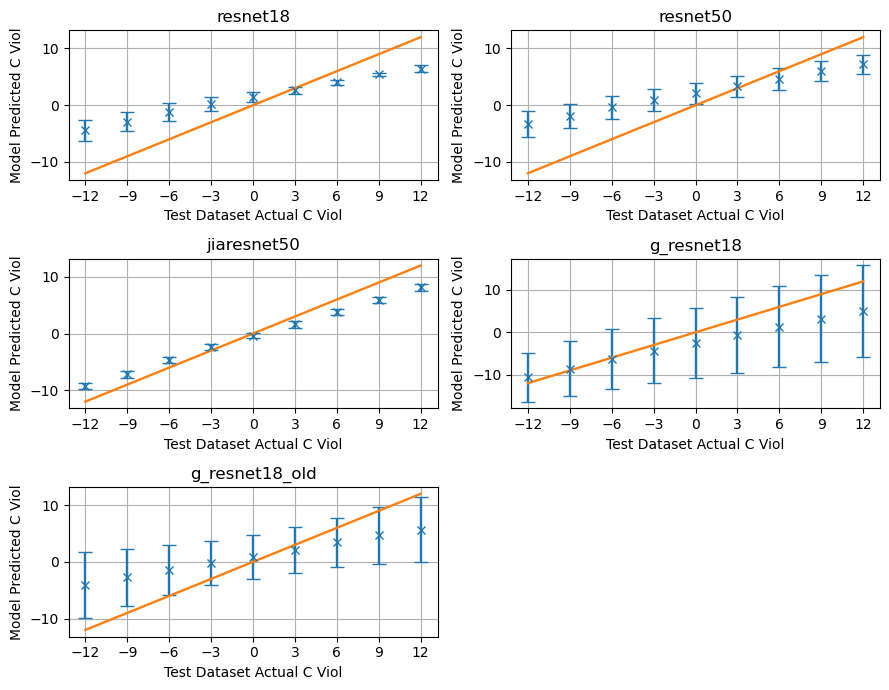

In [28]:
model_ids = ['resnet18_cut_dataset_repeat',
             'resnet50_cut_dataset_repeat',
            'jiaresnet50_cut_dataset_repeat',
             'g_resnet18_cut_dataset_repeat',
            'g_resnet18_old_cut_dataset_repeat']
chirality_list = [-12,-9,-6,-3,0,3,6,9,12]
cviol_table = get_predict_results_runs_cviol(model_ids,chirality_list)
plot_cviols(cviol_table,model_ids,chirality_list)